In [1]:
import pandas as pd #导入Pandas
import numpy as np #导入Numpy
import jieba #导入结巴分词
import jieba.analyse
 
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU

print("————————语料预处理：数据导入————————")
reviewfile=pd.read_csv('review30000.csv') #读取训练语料完毕
reviewdata = pd.DataFrame()
reviewdata["reviewbody"]= reviewfile["b.reviewbody"]
reviewdata["score1"]= reviewfile["口味评分"]
reviewdata["score2"]= reviewfile["环境评分"]
reviewdata["score3"]= reviewfile["服务评分"]
reviewdata = reviewdata.dropna(axis=0,how='any') #去掉所有有缺失值的行
print("reviewdata的数据格式为：")
print(reviewdata.info())
print("【over】")


Using TensorFlow backend.


————————语料预处理：数据导入————————


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


reviewdata的数据格式为：
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 4 columns):
reviewbody    30000 non-null object
score1        30000 non-null float64
score2        30000 non-null float64
score3        30000 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.1+ MB
None
【over】


In [2]:
#【函数】查看pandas数据的信息
def getinfo(inputdata):
    print("文件的具体信息如下==========")
    info = inputdata.info()
    print(info)
    print("===========")

#【函数】分词&清洗无用词
def cutwords(review_data):
    cw = lambda x: list(jieba.cut(x)) 
    review_data['words'] = review_data["reviewbody"].apply(cw)
    print("——————————分词结束——————————")
    
    delwordslist = "，/,/。/的/！/～/、/（/）/ /./。/吧".split("/")
    for i in review_data.index:
        one = review_data.words[i]
        for k in one:
            if k in delwordslist:
                one.remove(k)
        i +=1
    print("——————————清洗无用词结束——————————")
    return review_data

#【函数】构建词频字典（输入的数据需要经过cutwords（））
def dict_words(review_data):
    w = []
    for i in review_data["words"]:
        w.extend(i)
    word_dict = pd.DataFrame(pd.Series(w).value_counts(),columns = ["counts"])
    word_dict.to_csv("word_dict(词组映射).csv",index=True,header=True)
    word_dict['id'] = list(range(1, len(word_dict)+1))
    getinfo(word_dict)
    word_dict.to_csv("word_dict(词组映射).csv",index=True,header=True)
    print("词典构建完成，输出文件word_dict(词组映射).csv——————【over】")
    return word_dict


#【函数】词向量化
def arraywords(review_data,word_dict):
    maxlen = 50
    review_data['sent'] = review_data['words'].apply(lambda x: list(word_dict['id'][x]))
    #review_data['sent'] = list(sequence.pad_sequences(review_data['sent'], maxlen=maxlen))
    review_data['sent'] = list(sequence.pad_sequences(review_data['sent'], maxlen=maxlen))
    print("——————————词向量化结束——————————")
    return review_data

#【函数】给数据打标:
def markwords(inputdata):
    inputdata["totalscore"] = inputdata.score1+inputdata.score2+inputdata.score3 
    inputdata["pos_or_neg"] = pd.Series()
    pos = inputdata[inputdata.totalscore>11]
    pos["pos_or_neg"]=1
    neg = inputdata[inputdata.totalscore<4]
    neg["pos_or_neg"] = 0
    inputdata = pos.append(neg)
    print("——————————标注结束——————————")
    print("得到{}条正向评论，{}条负向评论".format(len(pos),len(neg)))
    return inputdata

#【函数】训练过程可视化图表
import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [3]:
a = cutwords(reviewdata)
word_dict = dict_words(a)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/t9/186m3wkn1c1c1y1m9dmv76zh0000gn/T/jieba.cache
Loading model cost 3.832 seconds.
Prefix dict has been built succesfully.


——————————分词结束——————————
——————————清洗无用词结束——————————
文件的具体信息如下==========
<class 'pandas.core.frame.DataFrame'>
Index: 46955 entries, 了 to 心太
Data columns (total 2 columns):
counts    46955 non-null int64
id        46955 non-null int64
dtypes: int64(2)
memory usage: 1.1+ MB
None
词典构建完成，输出文件word_dict(词组映射).csv——————【over】


In [4]:
#开始调用函数处理数据：

reviewdata_sented = arraywords(a,word_dict)
print("完成（词向量化），得到 reviewdata_sented ：")
print(reviewdata_sented.info())
reviewdata_marked = markwords(reviewdata_sented)
reviewdata_marked.to_csv("reviewdata_marked(词组映射).csv",index=True,header=True)
print("完成（数据情感极性标注），输出文件reviewdata_markeded(词组映射).csv——————【over】")

——————————词向量化结束——————————
完成（词向量化），得到 reviewdata_sented ：
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 6 columns):
reviewbody    30000 non-null object
score1        30000 non-null float64
score2        30000 non-null float64
score3        30000 non-null float64
words         30000 non-null object
sent          30000 non-null object
dtypes: float64(3), object(3)
memory usage: 2.9+ MB
None


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


——————————标注结束——————————
得到13912条正向评论，1185条负向评论
完成（数据情感极性标注），输出文件reviewdata_markeded(词组映射).csv——————【over】


构建的模型信息为：
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         12020736  
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 12,415,234
Trainable params: 12,415,234
Non-trainable params: 0
_________________________________________________________________
下面开始训练
Train on 11322 samples, validate on 3775 samples
Epoch 1/10
11322/11322 [==============================] - 265s 2

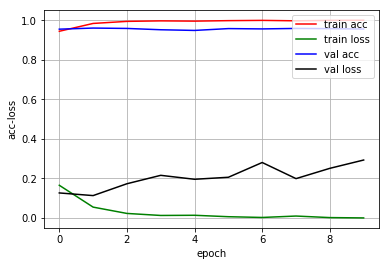

【over】


In [5]:
#进行神经网络模型搭建
from sklearn import model_selection
from keras.utils import np_utils

seed = 7
X = np.array(list(reviewdata_marked['sent']))
Y = np.array(list(reviewdata_marked['pos_or_neg']))
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=seed)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

model = Sequential()
model.add(Embedding(len(word_dict)+1, 256))
model.add(GRU(256))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("构建的模型信息为：")
model.summary()
model.get_config()

print("下面开始训练")


history = LossHistory()
model.fit(x_train, y_train, batch_size=32, epochs=10,validation_data=(x_test, y_test),callbacks=[history])#128时，每个epoch训练92s
history.loss_plot('epoch')
print("【over】")

In [6]:
score = model.evaluate(x_test, y_test, verbose=1) 
#【evaluate函数返回什么？？？】
#Scalar test loss (if the model has no metrics)or list of scalars (if the model computes other metrics).
#The attribute `model.metrics_names` will give you
#the display labels for the scalar outputs.
print ("Test accuracy = :",score)

3775/3775 [==============================] - 11s 3ms/step
Test accuracy = : [0.29336111755477301, 0.95549668850488223]


In [7]:
def predict_new(reviewdata):
    reviewdata_sent = arraywords(reviewdata,word_dict)
    x = np.array(list(reviewdata_sent['sent']))
    y = model.predict_classes(x)
    y_score = model.predict(x)
    y_out = y.tolist()
    y_score_out = y_score.tolist()
    predict_result = pd.DataFrame()
    predict_result["reviewinput"] = pd.Series(reviewdata.reviewbody)
    predict_result["p:pos_or_neg"] = y_out
    predict_result["p:score"] = y_score_out
    return predict_result

#输入一个评论来预测
def predict_one(review):
    words = re.findall('[\x80-\xff]{3}|[\w\W]', review)
    print("words = ",words)
    sent = []
    for x in words:
        get_id = list(word_dict["id"][word_dict.index == x].values)
        sent.extend(get_id)
    print("sent = ",sent)
    x_input = sequence.pad_sequences([sent], maxlen=25)
    print("x_input = ",x_input)
    predicted = model.predict_classes(x_input, verbose=0)
    return predicted

def new_data_predict(new_comment):
    words = list(jieba.cut(new_comment))
    sent = [word_dict['id'][x] for x in words]
    xn = sequence.pad_sequences([sent], maxlen=50)
    yn = model.predict_classes(xn,verbose = 0)
    y_score = model.predict(xn,verbose = 0)
    print("预测结果：",yn,y_score)

In [22]:
a = "他们都说好吃，我就呵呵了，这菜和自家随便炒炒有什么两样"
a2 = "和闺蜜来约饭，本帮菜里面一般般，一个炒地瓜太咸了，而且丸子都炒焦了是怎么回事？"
a3 = "不想吃家里的菜，每次都会来这儿，老板每次都会送一个汤，好幸福！"
a4 = "这家招牌菜是咖喱蟹，两个人吃了190多，加上券还是蛮划算的，下次可以考虑再来"
a5 = "嘻嘻吃到撑，怎么能给那么多虾仁嘞？老板你不要太爽快呀！"
new_data_predict(a)
new_data_predict(a2)
new_data_predict(a3)
new_data_predict(a4)
new_data_predict(a5)


预测结果： [0] [[ 0.85371554  0.14628449]]
预测结果： [0] [[  9.99963999e-01   3.60025115e-05]]
预测结果： [1] [[ 0.0933537   0.90664631]]
预测结果： [1] [[  1.06074005e-09   1.00000000e+00]]
预测结果： [1] [[  4.17949923e-06   9.99995828e-01]]
